# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [1]:
%load_ext autoreload
%autoreload 2

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [2]:
import numpy as np

# 1 Способ 
#import keras
#from keras.datasets import fashion_mnist
#(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

# 2 Способ (если первый не работает)
from sklearn.datasets import fetch_openml
def load_fashion_mnist():
     X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
     X = X.reshape(-1, 28, 28).astype('uint8')
     y = y.astype('int64')
     x_train, x_test = X[:60000], X[60000:]
     y_train, y_test = y[:60000], y[60000:]
     return (x_train, y_train), (x_test, y_test)
(x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()



x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент? 

**Ответ:** PCA здесь используется для понижения размерности выборки, сохраняя наиболее важную информацию о данных (за счеь того, что сохраняются главные компоненты). Во-первых, уменьшаются вычислительные затраты, так как используется меньше признаков. Во-вторых, снижается вероятность переобучения, потому что модель строится на более информативных признаках, и мы выкидываем шум и неполезные признаки. В-третьих, оптимизируется ядро RFF, так как низкоразмерное пространство позволяет более эффективно аппроксимировать ядро

__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [3]:
from sklearn.exceptions import ConvergenceWarning
from warnings import filterwarnings

filterwarnings('ignore', category=ConvergenceWarning)

In [4]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator

pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train, y_train)

accuracy = pipeline.score(x_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8581


__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost. 

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [5]:
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

In [6]:
svm_linear = LinearSVC(dual=False)
start_time = time.time()
svm_linear.fit(x_train, y_train)
end_time = time.time() 

y_pred = svm_linear.predict(x_test)
svm_linear_accuracy = accuracy_score(y_test, y_pred)

print(f"Linear SVM: \n accuracy: {svm_linear_accuracy:.4f} \n time: {end_time-start_time:.4f} sec")

Linear SVM: 
 accuracy: 0.8378 
 time: 1482.0719 sec


In [7]:
svm_kernel = SVC(kernel='rbf')
start_time = time.time()
svm_kernel.fit(x_train[:20000], y_train[:20000])
end_time = time.time() 

y_pred = svm_kernel.predict(x_test)
svm_kernel_accuracy = accuracy_score(y_test, y_pred)

print(f"Kernel SVM: \n accuracy: {svm_kernel_accuracy:.4f} \n time: {end_time-start_time:.4f} sec")

Kernel SVM: 
 accuracy: 0.8639 
 time: 27.6115 sec


In [8]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator


rff_pipeline = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, classifier_class=LinearSVC ,feature_creator_class=RandomFeatureCreator)
start_time = time.time()
rff_pipeline.fit(x_train, y_train)
end_time = time.time() 

y_pred = rff_pipeline.predict(x_test)
rff_accuracy = accuracy_score(y_test, y_pred)

print(f"Random + Linear SVM: \n accuracy: {rff_accuracy:.4f} \n time: {end_time-start_time:.4f} sec")

Random + Linear SVM: 
 accuracy: 0.8628 
 time: 122.7993 sec


*извиняюсь, но на новом ноуте не получается установить catboost или lightgbm, так что сделала так*

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(x_train)
X_test_pca = pca.transform(x_test)

gb_model = GradientBoostingClassifier(n_estimators=100, verbose=0)
start_time = time.time()
gb_model.fit(X_train_pca, y_train)
end_time = time.time()

y_pred = gb_model.predict(X_test_pca)
gb_accuracy = accuracy_score(y_test, y_pred)

print(f"Gradient Boosting + PCA: \n accuracy: {gb_accuracy:.4f} \n time: {end_time-start_time:.4f} sec")


Gradient Boosting + PCA: 
 accuracy: 0.8351 
 time: 843.1239 sec


__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

With Logreg (for use_PCA=True and use_PCA=False)

In [10]:
rff_pipeline_pca = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, feature_creator_class=RandomFeatureCreator)
rff_pipeline_pca.fit(x_train, y_train)
y_pred_pca = rff_pipeline_pca.predict(x_test)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"with PCA: accuracy = {accuracy_pca:.4f}")

with PCA: accuracy = 0.8581


In [11]:
rff_pipeline_no_pca = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, feature_creator_class=RandomFeatureCreator)
rff_pipeline_no_pca.fit(x_train, y_train)
y_pred_no_pca = rff_pipeline_no_pca.predict(x_test)
accuracy_no_pca = accuracy_score(y_test, y_pred_no_pca)
print(f"without PCA: accuracy = {accuracy_no_pca:.4f}")

without PCA: accuracy = 0.8606


With Linear SVM (for use_PCA=True and use_PCA=False)

In [12]:
rff_pipeline_svm = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier_class=LinearSVC,feature_creator_class=RandomFeatureCreator)
rff_pipeline_svm.fit(x_train, y_train)
y_pred_svm = rff_pipeline_svm.predict(x_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"with PCA: accuracy = {accuracy_svm:.4f}")

with PCA: accuracy = 0.8768


In [13]:
rff_pipeline_svm = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, classifier_class=LinearSVC, feature_creator_class=RandomFeatureCreator)
rff_pipeline_svm.fit(x_train, y_train)
y_pred_svm = rff_pipeline_svm.predict(x_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"without PCA: accuracy = {accuracy_svm:.4f}")

without PCA: accuracy = 0.8635


с линейным SVM получается немного выше точность, чем с логистической регрессией, но не значительно

предварительное понижение размерности при помощи PCA дает некоторое ухудшение по точности, но не значительное (для логрега), для линейного SVM - незначительное улучшение

In [14]:
n_features_val = [10, 25, 50, 100, 200, 350, 500, 1000, 2000]
accuracies = []

for n in n_features_val:
    rff_pipeline = RFFPipeline(n_features=n, new_dim=50, use_PCA=True, feature_creator_class=RandomFeatureCreator)
    rff_pipeline.fit(x_train, y_train)
    y_pred = rff_pipeline.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    print(f"n_features = {n}: accuracy = {acc:.4f}")


n_features = 10: accuracy = 0.6105
n_features = 25: accuracy = 0.7471
n_features = 50: accuracy = 0.8032
n_features = 100: accuracy = 0.8359
n_features = 200: accuracy = 0.8465
n_features = 350: accuracy = 0.8525
n_features = 500: accuracy = 0.8548
n_features = 1000: accuracy = 0.8609
n_features = 2000: accuracy = 0.8586


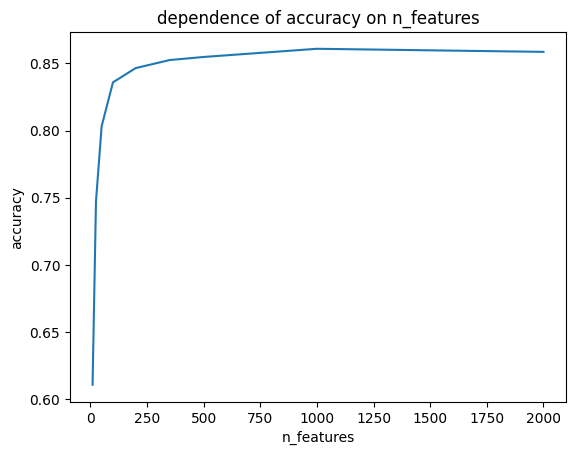

In [15]:
import matplotlib.pyplot as plt

plt.plot(n_features_val, accuracies)
plt.xlabel('n_features')
plt.ylabel('accuracy')
plt.title('dependence of accuracy on n_features')
plt.show()

действительно выходит на плато при росте n_features: как можно заметить при n_features=500 и выше точность практически не меняется

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы. 


In [16]:
'''rff_pipeline = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, feature_creator_class=RandomFeatureCreator)
rff_pipeline.fit(x_train, y_train)
y_pred = rff_pipeline.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy rff= {acc:.4f}")'''

'rff_pipeline = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, feature_creator_class=RandomFeatureCreator)\nrff_pipeline.fit(x_train, y_train)\ny_pred = rff_pipeline.predict(x_test)\nacc = accuracy_score(y_test, y_pred)\nprint(f"accuracy rff= {acc:.4f}")'

In [17]:
'''from homework_practice_08_rff import OrthogonalRandomFeatureCreator

orff_pipeline = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, feature_creator_class=OrthogonalRandomFeatureCreator)
orff_pipeline.fit(x_train, y_train)
y_pred = orff_pipeline.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy orff= {acc:.4f}")'''

'from homework_practice_08_rff import OrthogonalRandomFeatureCreator\n\norff_pipeline = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, feature_creator_class=OrthogonalRandomFeatureCreator)\norff_pipeline.fit(x_train, y_train)\ny_pred = orff_pipeline.predict(x_test)\nacc = accuracy_score(y_test, y_pred)\nprint(f"accuracy orff= {acc:.4f}")'

__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___

___описание идеи:___

In [18]:
# Пример 

__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**. 
Подумайте о том, как в формулах правильно учесть свободный коэффициент. 

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___ 


1. 

$$

\frac{1}{2} ||\Phi \Phi^T w - y||^2 = \frac{1}{2} (\Phi \Phi^T w - y)^T (\Phi \Phi^T w - y)

$$

$$

\nabla_w \left( \frac{1}{2} (\Phi \Phi^T w - y)^T (\Phi \Phi^T w - y) \right) = \Phi \Phi^T (\Phi \Phi^T w - y)

$$

2.
$$

\frac{\lambda}{2} w^T \Phi \Phi^T w = \frac{\lambda}{2} w^T K w

$$
$$

\nabla_w \left( \frac{\lambda}{2} w^T K w \right) = \lambda K w

$$

Итого получаем:

$$

\nabla_w Q(w) = \Phi \Phi^T (\Phi \Phi^T w - y) + \lambda K w = K (\Phi \Phi^T w - y) + \lambda K w

$$


Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

я решила написать тут, а не писать в шаблоне, надеюсь это ок

In [19]:
class KernelRidgeRegression:
    def __init__(self, kernel='rbf', lambda_reg=1.0, use_analytic=False, max_iter=1000, 
                 learning_rate=0.01, gamma=1.0, tol=1e-6):
        self.kernel_type = kernel
        self.lambda_reg = lambda_reg
        self.use_analytic = use_analytic
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tol = tol  
        self.alpha = None
        self.X_train = None
        self.bias = 0

    def compute_kernel(self, X1, X2):
        if self.kernel_type == 'rbf':
            n_samples1, n_samples2 = X1.shape[0], X2.shape[0]
            distances = []
            n_pairs = min(10000, n_samples1 * n_samples2)
        
            while len(distances) < n_pairs:
                idx1 = np.random.randint(0, n_samples1)
                idx2 = np.random.randint(0, n_samples2)
            
                if idx1 != idx2:
                    dist = np.sum((X1[idx1] - X2[idx2]) ** 2)
                    distances.append(dist)
        
            sigma_squared = np.median(np.array(distances))
            gamma = 1 / (2 * sigma_squared + 1e-8)  
            K = np.zeros((n_samples1, n_samples2))
            for i in range(n_samples1):
                for j in range(n_samples2):
                    sq_dist = np.sum((X1[i] - X2[j]) ** 2)
                    K[i, j] = np.exp(-gamma * sq_dist)
        
            return K
        elif self.kernel_type == 'linear':
            return np.dot(X1, X2.T)

    def fit(self, X, y):
        self.X_train = X
        n_samples = X.shape[0]
        
        y_centered = y - np.mean(y)
        self.bias = np.mean(y)

        K = self.compute_kernel(X, X)
        
        if self.use_analytic:
            self.alpha = np.linalg.solve(K + self.lambda_reg * np.eye(n_samples), y_centered)
        else:
            self.alpha = np.zeros(n_samples)
            prev_loss = float('inf')
            
            for i in range(self.max_iter):
                pred = K.dot(self.alpha)
                grad = K.dot(pred - y_centered) + self.lambda_reg * K.dot(self.alpha)
                grad_norm = np.linalg.norm(grad)
                if grad_norm > 1:
                    grad = grad / grad_norm
        
                self.alpha -= self.learning_rate * grad
                
                current_loss = 0.5 * np.sum((pred - y_centered) ** 2) + \
                             0.5 * self.lambda_reg * self.alpha.dot(K.dot(self.alpha))
                
                if abs(prev_loss - current_loss) < self.tol:
                    break
                    
                prev_loss = current_loss

    def predict(self, X):
        K_test = self.compute_kernel(X, self.X_train)
        return K_test.dot(self.alpha) + self.bias


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
np.random.seed(42)
    
n_samples = 3000
X = np.random.randn(n_samples, 2)
true_func = lambda x: np.sin(x[:, 0]) + np.cos(x[:, 1])
y = true_func(X) + np.random.normal(0, 0.1, n_samples)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_analytic = KernelRidgeRegression(kernel='rbf', use_analytic=True, lambda_reg=0.1, gamma=1.0)
model_gradient = KernelRidgeRegression(kernel='rbf', use_analytic=False, lambda_reg=0.1, gamma=1.0, 
                                          learning_rate=0.01, max_iter=1000)
model_analytic_linear = KernelRidgeRegression(kernel='linear', use_analytic=True, lambda_reg=0.1, gamma=1.0)
model_gradient_linear = KernelRidgeRegression(kernel='linear', use_analytic=False, lambda_reg=0.1, gamma=1.0, 
                                          learning_rate=0.01, max_iter=1000)

model_analytic.fit(X_train, y_train)
model_gradient.fit(X_train, y_train)
model_analytic_linear.fit(X_train, y_train)
model_gradient_linear.fit(X_train, y_train)

pred_analytic = model_analytic.predict(X_test)
pred_gradient = model_gradient.predict(X_test)
pred_analytic_linear = model_analytic_linear.predict(X_test)
pred_gradient_linear = model_gradient_linear.predict(X_test)

print("MSE (analytic):", mean_squared_error(y_test, pred_analytic))
print("MSE (gradient):", mean_squared_error(y_test, pred_gradient))
print("MSE (analytic_linear):", mean_squared_error(y_test, pred_analytic_linear))
print("MSE (gradient_linear):", mean_squared_error(y_test, pred_gradient_linear))

MSE (analytic): 0.010313441371516744
MSE (gradient): 0.03719780263184441
MSE (analytic_linear): 0.24677823920864825
MSE (gradient_linear): 0.3986960462092339
